## POS tagging using modified Viterbi

## Below are steps followed to assign POS tagging

<ul>
    <li>The vanilla Viterbi algorithm is devloped for assigning POS tags (i.e. without dealing with unknown words) </li>
    <li>In first modification technique Viterbi algorithm  we have modified in such way for unkown words we are considering transition probability</li>
    <li>In second modification technique Viterbi algorithm  we have modified in such way backoff to a rule based tagger in case of an unknown word</li>
   <li>Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.</li>
  </ul>

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
#lets check the length of data
print(len(nltk_data))

3914


In [5]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05,random_state = 101)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Reliance', 'NOUN'), ('confirmed', 'VERB'), ('the', 'DET'), ('filing', 'NOUN'), ('but', 'CONJ'), ('would', 'VERB'), ("n't", 'ADV'), ('elaborate', 'VERB'), ('.', '.')], [('*', 'X'), ('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.')], [('Because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('rulings', 'NOUN'), (',', '.'), ('the', 'DET'), ('Commerce', 'NOUN'), ('Department', 'NOUN'), ('will', 'VERB'), ('continue', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('investigate', 'VERB'), ('complaints', 'NOUN'), ('*ICH*-2', 'X'), ('by', 'ADP'), ('U.S.', 'NOUN'), ('sweater', 'NOUN'), ('makers', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('imports', 'NOUN'), ('are', 'VERB'), ('reaching', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('at', 'ADP'), ('unfairly', 'ADV'), ('low', 'ADJ'), ('prices', 'NOUN'), ('in', 'ADP'), ('violation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('anti-dumping', 'ADJ'), ('act', 'NOUN'), ('.', '.')], [('What', 'PRON'), ('she',

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95547

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*']

In [8]:
V = set(tokens)
print(len(V))

12100


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print(T)

{'ADJ', 'PRT', '.', 'PRON', 'NUM', 'X', 'ADV', 'VERB', 'ADP', 'NOUN', 'CONJ', 'DET'}


### Build the vanilla Viterbi based POS tagger

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
#lets print tags_matrix
tags_matrix

array([[6.64030313e-02, 1.07101668e-02, 6.39314577e-02, 3.29543574e-04,
        2.12555602e-02, 2.10907888e-02, 4.77838190e-03, 1.16987973e-02,
        7.82665983e-02, 6.99621022e-01, 1.69714950e-02, 4.94315382e-03],
       [8.30313042e-02, 1.64744642e-03, 4.38220762e-02, 1.77924223e-02,
        5.66721596e-02, 1.35090612e-02, 1.02141676e-02, 4.05271828e-01,
        2.00988464e-02, 2.47775942e-01, 2.30642501e-03, 9.78583172e-02],
       [4.39629592e-02, 2.42740265e-03, 9.33201462e-02, 6.63490072e-02,
        8.10033232e-02, 2.69711409e-02, 5.23240119e-02, 8.90946686e-02,
        9.13422629e-02, 2.22242206e-01, 5.75384349e-02, 1.73334539e-01],
       [7.31240436e-02, 1.30168451e-02, 4.09647785e-02, 7.65696773e-03,
        6.50842255e-03, 8.99693742e-02, 3.40735056e-02, 4.85451758e-01,
        2.29709037e-02, 2.10949466e-01, 5.35987737e-03, 9.95405857e-03],
       [3.42465751e-02, 2.65038721e-02, 1.17331743e-01, 1.48898154e-03,
        1.84931502e-01, 2.10541993e-01, 2.97796307e-03, 1.87

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [17]:
tags_df

,ADJ,PRT,.,PRON,NUM,X,ADV,VERB,ADP,NOUN,CONJ,DET
ADJ,0.066403,0.010710,0.063931,0.000330,0.021256,0.021091,0.004778,0.011699,0.078267,0.699621,0.016971,0.004943
PRT,0.083031,0.001647,0.043822,0.017792,0.056672,0.013509,0.010214,0.405272,0.020099,0.247776,0.002306,0.097858
.,0.043963,0.002427,0.093320,0.066349,0.081003,0.026971,0.052324,0.089095,0.091342,0.222242,0.057538,0.173335
PRON,0.073124,0.013017,0.040965,0.007657,0.006508,0.089969,0.034074,0.485452,0.022971,0.210949,0.005360,0.009954
NUM,0.034247,0.026504,0.117332,0.001489,0.184932,0.210542,0.002978,0.018761,0.036033,0.350208,0.013699,0.003276
X,0.017187,0.185232,0.163590,0.055538,0.002864,0.076384,0.024984,0.203851,0.142584,0.062381,0.010662,0.054742
ADV,0.129182,0.014243,0.137131,0.014906,0.030474,0.023186,0.080490,0.343491,0.118582,0.031467,0.006956,0.069891
VERB,0.064988,0.030674,0.034934,0.035786,0.022851,0.217506,0.081952,0.169249,0.092022,0.110070,0.005577,0.134392
ADP,0.107024,0.001390,0.039025,0.070031,0.062226,0.034427,0.014006,0.008340,0.016893,0.320967,0.000962,0.324709
NOUN,0.012248,0.043397,0.240604,0.004607,0.009542,0.029175,0.017074,0.147667,0.176514,0.263564,0.042666,0.012942


In [18]:
tags_df.loc['.', :]

ADJ     0.043963
PRT     0.002427
.       0.093320
PRON    0.066349
NUM     0.081003
X       0.026971
ADV     0.052324
VERB    0.089095
ADP     0.091342
NOUN    0.222242
CONJ    0.057538
DET     0.173335
Name: ., dtype: float32

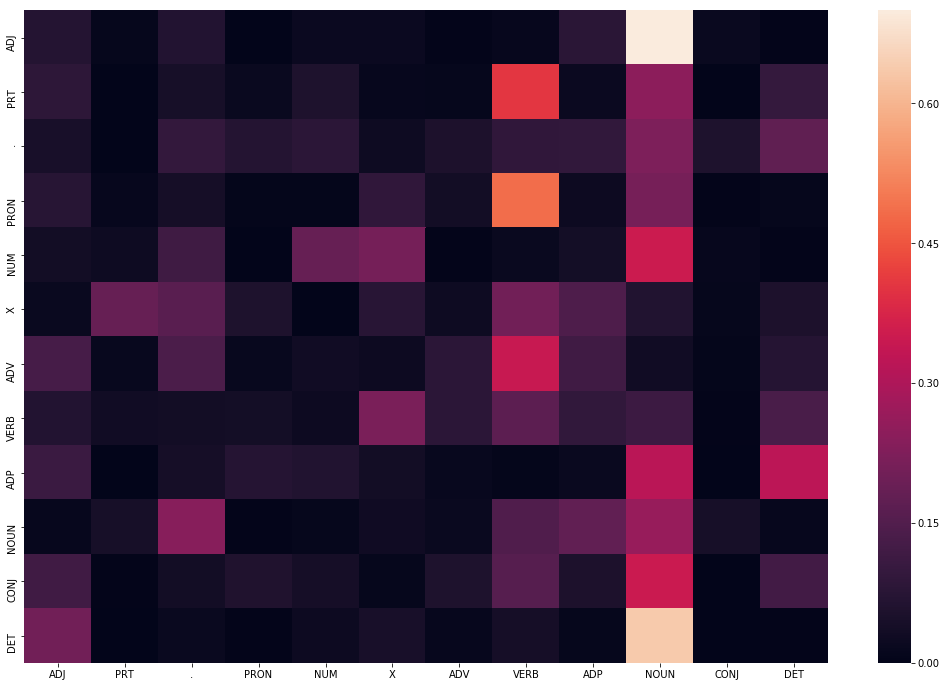

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

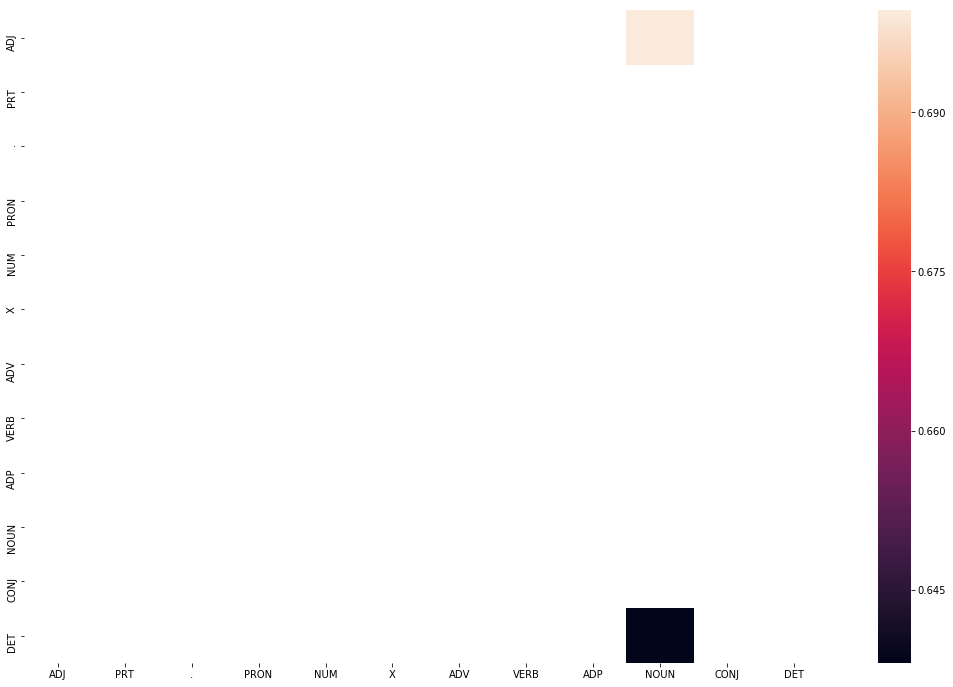

In [20]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [21]:
#lets check the length of train_tagged_words
len(train_tagged_words)

95547

## Viterbi algorithm for assigning POS tags 

For each word, we compute the P(tag|word) for each tag in the tag set and then assign the tag having the max P(tag/word).

 

P(tag|word)  = (emission probability of the word-tag pair) * (transition probability from the previous tag).

 

As we move along each word, we keep on storing the assigned tags in a list. As we progress further down the sequence, each word uses the tag of the previous token to compute the transition probabilities. 

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('Contra', 'NOUN'),
  ('military', 'ADJ'),
  ('command', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('statement', 'NOUN'),
  ('from', 'ADP'),
  ('Honduras', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Sandinista', 'NOUN'),
  ('troops', 'NOUN'),
  ('had', 'VERB'),
  ('launched', 'VERB'),
  ('a', 'DET'),
  ('major', 'ADJ'),
  ('offensive', 'NOUN'),
  ('against', 'ADP'),
  ('the', 'DET'),
  ('rebel', 'NOUN'),
  ('forces', 'NOUN'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Bucking', 'VERB'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('trend', 'NOUN'),
  (',', '.'),
  ('an', 'DET'),
  ('issue', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('from', 'ADP'),
  ('Detroit', 'NOUN'),
  (',', '.'),
  ('Mich.', 'NOUN'),
  (',', '.'),
  ('apparently', 'ADV'),
  ('drew'

In [24]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [25]:
print("Time taken in seconds: ", difference)

Time taken in seconds:  72.8283634185791


In [26]:
print(tagged_seq)

[('The', 'DET'), ('Contra', 'ADJ'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'ADJ'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'ADJ'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'ADJ'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'ADJ'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'ADJ'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'ADJ'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN'), ('s

In [27]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [28]:
accuracy = len(check)/len(tagged_seq)
print("Accuracy of Viterbi Algorithm: ", accuracy)

Accuracy of Viterbi Algorithm:  0.8938053097345132


In [29]:
# let's check the incorrectly tagged words
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('The', 'DET'), (('Contra', 'ADJ'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'ADJ'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'ADJ'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', 'ADJ'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', 'ADJ'), ('rebel', 'NOUN'))],
 [('*-1', 'X'), (('Bucking', 'ADJ'), ('Bucking', 'VERB'))],
 [('apparently', 'ADV'), (('drew', 'ADJ'), ('drew', 'VERB'))],
 [('its', 'PRON'), (('Eveready', 'ADJ'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'ADJ'), ('*T*-252', 'X'))],
 [('*-1', 'X'), (('complaining', 'ADJ'), ('complaining', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

### Solve the problem of unknown words

We can see that all of unknown words have been tagged as 'ADJ' as 'ADJ' is the first tag in tag list and is assigned if unknown word is encountered (emission probability =0).

## First Viterbi Modification Technique
If emission probability for unknown word is zero then assign based on transition probabilities

In [30]:
def Viterbi_firstTechnique(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        #initialise list for storing transition probabilities
        p_transition =[] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [31]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_firstTechnique(test_tagged_words)
end = time.time()
difference = end-start

In [32]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

In [33]:
print("Time taken in seconds: ", difference)
print("Modified Viterbi algorithm accuracy: ",accuracy)

Time taken in seconds:  71.25202107429504
Modified Viterbi algorithm accuracy:  0.9469026548672567


**As compared to plan Viterbi algorithm we have got better accuracy**

In [34]:
#lets check incorrectly tagged words  
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'DET'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'VERB'), ('Sandinista', 'NOUN'))],
 [('its', 'PRON'), (('Eveready', 'VERB'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'VERB'), ('*T*-252', 'X'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

As compare to plan Viterbi algorithm the below words are correctly tagged by modified Viterbi algorithm
<ul>
    <li>Contra correctly tagged as NOUN</li>
    <li>offensive correctly tagged as NOUN</li>
    <li>rebel correctly tagged as NOUN</li>
    <li>Bucking correctly tagged as VERB</li>
    <li>complaining correctly tagged as VERB</li>
</ul>

## Second Viterbi Algorithm Modification Technique
Backoff to rule based tagger in case unknown word is encountered.

Lets define rule based tagger

In [35]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

In [36]:
regexp_tagger = nltk.RegexpTagger(patterns)

In [37]:
def Viterbi_secondTechnique(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = regexp_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            state_max = regexp_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))

In [38]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_secondTechnique(test_tagged_words)
end = time.time()
difference = end-start

In [39]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

In [40]:
print("Time taken in seconds: ", difference)
print("accuracy: ",accuracy)

Time taken in seconds:  69.05897974967957
accuracy:  0.9734513274336283


**As compared to plan Viterbi algorithm and first modification technique we have got better accuracy**

In [41]:
# let's check the incorrectly tagged words
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('apparently', 'ADV'), (('drew', 'NOUN'), ('drew', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

As compare to plan Viterbi algorithm and first modification technique the below words are correctly tagged by second modified Viterbi algorithm
<ul>
    <li>Honduras correctly tagged as NOUN</li>
    <li>Sandinista correctly tagged as NOUN</li>
    <li>Eveready correctly tagged as NOUN</li>
</ul>

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Evaluating vanilla Viterbi and modified Viterbi on entire test data

In [43]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base = [tup for sent in test_set for tup in sent]

In [44]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

In [45]:
print("Time taken in seconds: ", difference)
print("accuracy: ",accuracy)

Time taken in seconds:  2960.5525119304657
accuracy:  0.9179177227529733


In [46]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_secondTechnique(test_tagged_words)
end = time.time()
difference = end-start

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print("Time taken in seconds: ", difference)
print("accuracy: ",accuracy)

Time taken in seconds:  2681.4329175949097
accuracy:  0.9537921622148567


**The accuracy of plan Viterb algorithm is 91% and modified Viterb algorithm is 95%**

## Evaluate tagging on "Test_sentences.txt" file 

In [47]:
file = open('Test_sentences.txt')

In [48]:
#read text from file
text = file.read()

In [49]:
#Split the text in sentences
sample_test_sent = text.splitlines()

In [50]:
file.close()

In [51]:
#lets check file contain
sample_test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [52]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]

In [53]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  89.3694384098053


In [54]:
sample_tagged_seq

[('Android', 'ADJ'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'ADJ'),
 ('Android', 'ADJ'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADJ'),
 ('worldwide', 'ADJ'),
 ('on', 'ADP'),
 ('smartphones', 'ADJ'),
 ('since', 'ADP'),
 ('2011', 'ADJ'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'ADJ'),
 ('Google', 'ADJ'),
 ('and', 'CONJ'),
 ('Twitter', 'ADJ'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADJ'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADJ'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'ADJ'),
 ('firehose.', 'ADJ'),
 ('Twitter', 'ADJ'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET'),
 ('users',

In [55]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi_secondTechnique(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  102.51097202301025


In [56]:
sample_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Below are the cases which are incorrectly tagged by the original Viterbi POS tagger
<ul>
<li>Android is incorrectly tag to ADJ</li>
<li>OS is incorrectly tag to ADJ</li>
<li>Google is incorrectly tag to ADJ</li>
<li>Europe is incorrectly tag to ADJ</li>
</ul>

We can se above after modifing the Vanilla Viterbi Algorithm the incorrectly taged word got tag correctly
<ul>
<li>Android is correctly tag to NOUN</li>
<li>OS is correctly tag to NOUN</li>
<li>Google is correctly tag to NOUN</li>
<li>Europe is correctly tag to NOUN</li>
</ul>